In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
import scipy.stats as stats
import sklearn

from sklearn.model_selection import train_test_split # split test and train
from IPython.display import display


# import data
data1 = pd.read_csv("https://raw.githubusercontent.com/kkeller88/Python-Practice/master/SVM_Academic_Performance/xAPI-Edu-Data.csv")
data1.head(n=5)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


# Preliminary Analyses


In [2]:
# get number of observarions
nobs = data1.shape[1]
print('There are {0} subjects in the dataset.'.format(nobs))

# look at number at each school level
levels_education = data1.groupby('StageID').count()['Class']
print('There are {0} participants in lower levels of school, {1} patients in middle school, and {2} patients in high school'.format(levels_education[0],levels_education[1],levels_education[2]))

There are 17 subjects in the dataset.
There are 33 participants in lower levels of school, 248 patients in middle school, and 199 patients in high school


### Categorical Variables

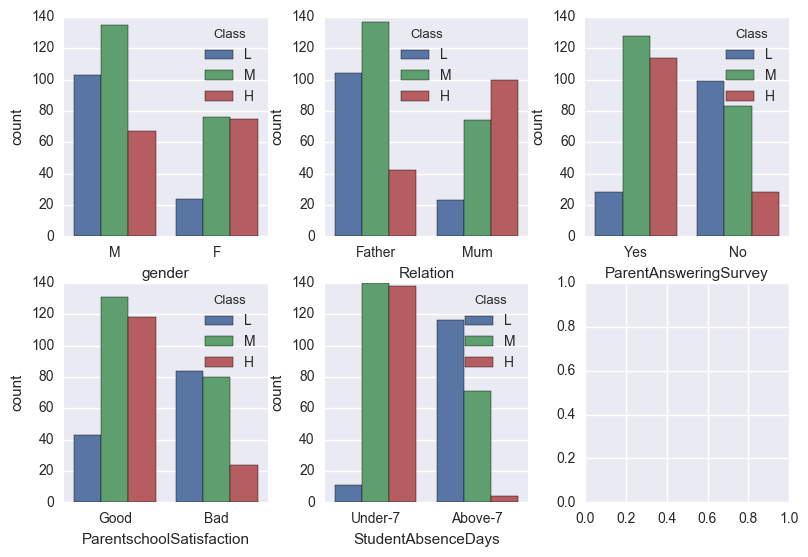

In [3]:
### PLOT CATEGORICAL VARIABLES AND OUTCOME

cat_var_list = ['gender','Relation','ParentAnsweringSurvey','ParentschoolSatisfaction','StudentAbsenceDays']
fig, axs = plt.subplots(ncols=3,nrows=2)
fig.tight_layout()
countr = 0

# make plot
for var in cat_var_list:
    
    # get right row
    j_col = countr % 3
    i_row = mt.floor(countr/3)

    # check
    # print('row number = {0}, col number = {1}'.format(i_row,j_col))
    
    # print plot
    sns.countplot(x=data1[var],hue=data1['Class'],hue_order=['L','M','H'],ax=axs[i_row,j_col])
    
    # update counter
    countr = countr + 1

plt.show()


In [4]:
### UNIVARIATE TESTS: Chi square tests

chi2_list = []

for var in cat_var_list:
    # contingency table
    cont_table = pd.crosstab(data1['Class'],data1[var])
    cont_array = cont_table.as_matrix()

    # calculate chi square stat
    test_stat, p, df, expected = stats.chi2_contingency(cont_array)

    # save results
    chi2_list.append({'Variable':var,'Test Statistic':test_stat,'Degrees of Freedom':df,'P Value*':p})

# save as df    
chi2_results = pd.DataFrame(chi2_list)
chi2_results = chi2_results[['Variable','Test Statistic','Degrees of Freedom','P Value*']]
display(chi2_results)
print('* no adjustment for multiple comparisons')

,Variable,Test Statistic,Degrees of Freedom,P Value*
0,gender,33.326236,2,5.798288e-08
1,Relation,81.365542,2,2.146333e-18
2,ParentAnsweringSurvey,95.364649,2,1.958076e-21
3,ParentschoolSatisfaction,68.469517,2,1.355293e-15
4,StudentAbsenceDays,225.204820,2,1.251396e-49


* no adjustment for multiple comparisons


Based on these simple plots is appears that female students, students for which the mother is responsible, students for which parents answered surveys, students with higher parent satisfaction and students with lower absense rated preformed better. Based on  a series of chi-square tests, is appears that all of the variables are associated with the outcome variable. 


### Continuous Variables

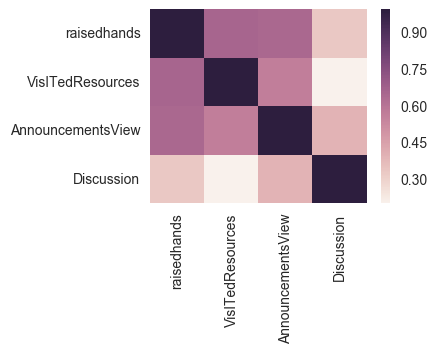

In [5]:
### correlation

# get subset of data
cont_list = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']

# print
plt.subplots(figsize=(3.5,2.5))
corrmat = data1[cont_list].corr(method='spearman')
sns.heatmap(corrmat)
plt.show()

The correlation between participating in discussion and raising hands in class is surprisingly low, I would think students that are talkative in class would be participating in discussion and raising their hands. 

/Users/kristenkeller/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


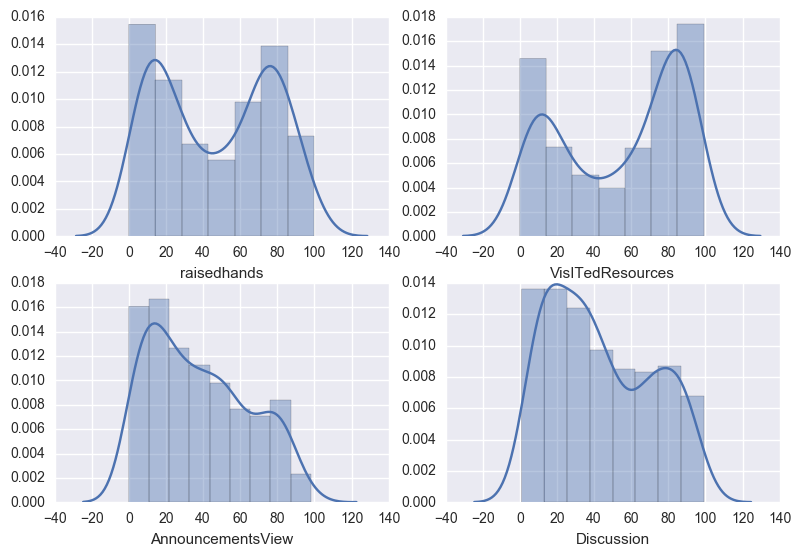

In [6]:
# continuous distributions
fig, axs = plt.subplots(ncols=2,nrows=2)
fig.tight_layout()
countr = 0

for var in cont_list:
    
    # get right row
    j_col = countr % 2
    i_row = mt.floor(countr/2)
    
    # plot
    sns.distplot(data1[var],ax=axs[i_row,j_col])

    # unpdate counter
    countr = countr + 1

plt.show()

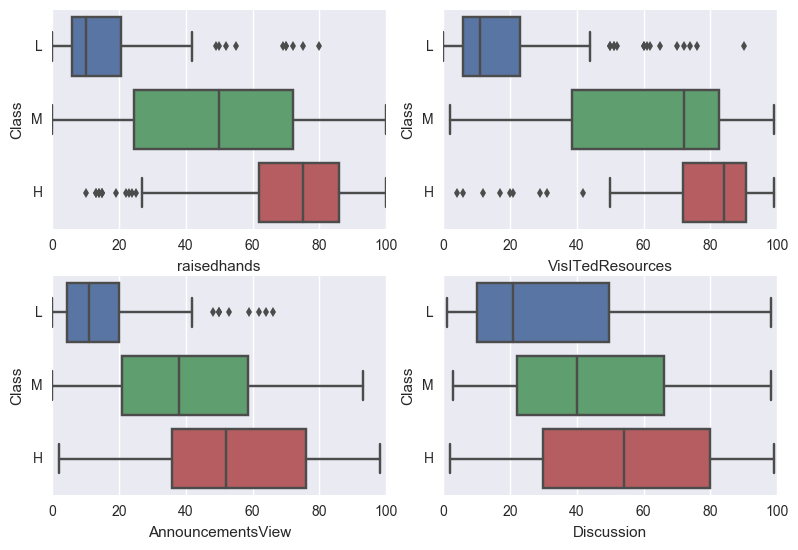

In [7]:
# barplots by group
cont_list = ['raisedhands','VisITedResources','AnnouncementsView','Discussion']
fig, axs = plt.subplots(ncols=2,nrows=2)
fig.tight_layout()
countr = 0

for var in cont_list:
    
    # get right row
    j_col = countr % 2
    i_row = mt.floor(countr/2)
    
    sns.boxplot(y=data1['Class'],x=data1[var],orient='h',ax=axs[i_row,j_col],order=['L','M','H'])
    
    # update counter
    countr = countr+1
    
plt.show()

Based on these simple plots it appears that lower preforming students raised their hands less, visited resources less, viewed anouncments less, and participated in discussion less. 

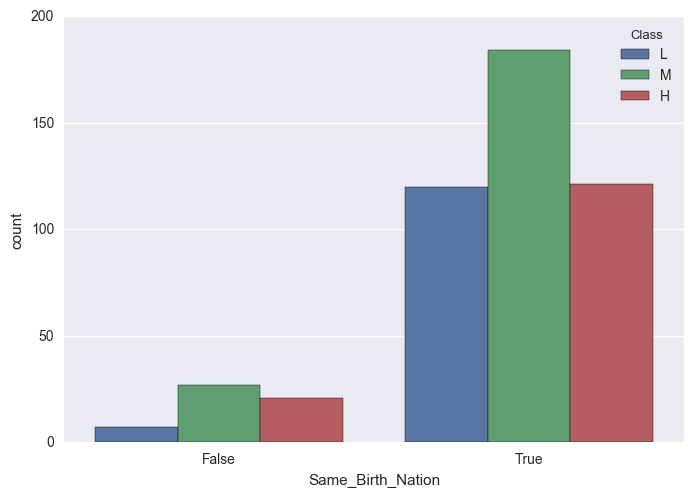

In [8]:
### create a variable to see if country of birth and nationality are the same - could be language/cultural issues

# make sure 2 variables are compatible
unique_nationality = data1['NationalITy'].unique() #KW
unique_birth = data1['PlaceofBirth'].unique() # Kuwait
differences = list(set(unique_nationality)-set(unique_birth))
data1['NationalITy'] = data1['NationalITy'].replace('KW','KuwaIT')

# make sure this fixed issue
differences2 = list(set(data1['NationalITy'].unique())-set(data1['PlaceofBirth'].unique()))

# create a variable to represent whether nationality and birthplace variable match
data1['Same_Birth_Nation'] = data1['NationalITy'].eq(data1['PlaceofBirth'])

# see how have different nationality and country of birth
levels_education = data1.groupby('Same_Birth_Nation').count()['Class']

# plot
sns.countplot(x=data1['Same_Birth_Nation'],hue=data1['Class'],hue_order=['L','M','H'])
plt.show()

It appears that participants whose nationality match their birth country preform worse. This is not what we expected.

In [9]:
# seperate dataframes into true and false on Same_Birth_Nation
Same_country = data1[data1['Same_Birth_Nation']==True]
Different_country = data1[data1['Same_Birth_Nation']==False]

# continuous variables 
print('Same Country:')
display(Same_country.describe())
print('Different Country:')
display(Different_country.describe())

# is there a gender difference?
prop_male_same = Same_country.groupby('gender').count()['Class'][1]/Same_country.shape[0]
prop_male_dif = Different_country.groupby('gender').count()['Class'][1]/Different_country.shape[0]

print('Proportion male in same country dataset: {0}. \nProportion male in different country dataset: {1}'.format(round(prop_male_same,2),round(prop_male_dif,2)))


Same Country:


,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,425.000000,425.000000,425.000000,425.000000
mean,43.967059,53.080000,35.828235,42.390588
std,30.003205,33.321096,25.819971,27.560618
min,0.000000,0.000000,0.000000,1.000000
25%,15.000000,17.000000,13.000000,19.000000
50%,40.000000,62.000000,32.000000,37.000000
75%,72.000000,83.000000,54.000000,68.000000
max,100.000000,99.000000,98.000000,99.000000


Different Country:


,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,55.000000,55.000000,55.000000,55.000000
mean,68.472727,68.072727,54.072727,50.181818
std,28.172652,28.038237,27.328492,27.507636
min,4.000000,0.000000,1.000000,7.000000
25%,70.000000,54.000000,35.500000,27.000000
50%,78.000000,80.000000,54.000000,43.000000
75%,86.000000,88.000000,76.000000,79.500000
max,100.000000,98.000000,98.000000,98.000000


Proportion male in same country dataset: 0.63. 
Proportion male in different country dataset: 0.67


Based on the continuous variables, it appears that subjects whose birth country did not match their nationality participated in class a lot more. There does not appear to be a large gender difference across groups.

# Test train split

In [10]:
# preprocess data
data2 = data1.copy()
data2 = data2.apply(sklearn.preprocessing.LabelEncoder().fit_transform)

# 20% test 80% train
test_data,train_data = train_test_split(data2,test_size=0.2,random_state=5)

# seperate x and y
train_y = train_data['Class']
test_y = test_data['Class']
train_x = train_data.drop(['Class','PlaceofBirth','SectionID','StageID'],axis=1)
test_x = test_data.drop(['Class','PlaceofBirth','SectionID','StageID'],axis=1)

# SVM - All Variables Used

Three kernels will be used - linear, rbf, and 2nd degree polynomial. Depending on the kernel used, there will be different parameters to tune. All kernels will have a c parameter. When c is high, the cost of misclassifying points is high and models that correctly classify the training points will be favored. For low c, smoother surfaces and wider margins will be favored. The rbf kernel has a gamma parameter. The polynomial kernel has a parameter refered to here as coef0.

In [13]:
from sklearn import svm

# svm model
model1 = svm.SVC(random_state=98895)

# grid of parameters to search over 
param_grid = [
  {'C': [0.01,0.1,1,10,100,1000,5000], 'kernel': ['linear']},
  {'C': [0.01,0.1,1,10,100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
  {'C': [0.01,0.1,1,10,100], 'kernel': ['poly'], 'degree': [2], 'coef0' : [0.001,0.01,0.1,1,10] }
]

# fit models
model1_CV = sklearn.model_selection.GridSearchCV(model1,param_grid,cv=5)
model1_CV.fit(train_x,train_y)
model1_CV_out = model1_CV.cv_results_

# extract parameters with lowest training err
best_params = model1_CV.best_params_
param_order = model1_CV_out['params']
mean_test_acc = model1_CV_out['mean_test_score']

In [16]:
best_params
#print(param_order)
#print(mean_test_acc)

{'C': 1000, 'kernel': 'linear'}

A grid search was preformed in order to select a kernel and associated parameters. 3 fold cross validation was used. Originally, the values for c ranged from 0.01 to 100 for every kernel, however a linear kernel with a c of 100 had the lowest cross-validation prediction error on test data. Since this was the highest c value included in the search for the linear kernel, we added c values of 1000 and 5000 to the search for the linear kernel. A linear kernel with a c value of 1000 was chosen in this search.  


# To be continued ... 

